In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
#Generator block
def Generator(z_dim=10, im_chan=1, hidden_dim=64):
        z_dim = z_dim
        gen = nn.Sequential(
                nn.Sequential(
                nn.ConvTranspose2d(z_dim,hidden_dim * 4,kernel_size=3, stride=2),
                nn.BatchNorm2d(hidden_dim * 4),
                nn.ReLU(inplace=True)),
                nn.Sequential(
                nn.ConvTranspose2d(hidden_dim * 4,hidden_dim * 2,kernel_size=4, stride=1),
                nn.BatchNorm2d(hidden_dim * 2),
                nn.ReLU(inplace=True)),
                nn.Sequential(
                nn.ConvTranspose2d(hidden_dim * 2,hidden_dim,kernel_size=3, stride=2),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True)),
                nn.Sequential(
                nn.ConvTranspose2d(hidden_dim,im_chan,kernel_size=4, stride=2),
                nn.Tanh())
        )
        return gen

def unsqueeze_noise(noise):
        z_dim=noise.shape[1]
        return noise.view(len(noise), z_dim, 1, 1)

def forward(Generator, noise):
        x = unsqueeze_noise(noise)
        return Generator.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

model=Generator()
model
#noise=get_noise(128,64)
#noise.shape

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

In [ ]:
#Discriminator block
def Discriminator( im_chan=1, hidden_dim=16):
        disc = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(im_chan,hidden_dim,kernel_size=4, stride=2),
                nn.BatchNorm2d(hidden_dim),
                nn.LeakyReLU(0.2,inplace=True)
                ),
            nn.Sequential(
                nn.Conv2d(hidden_dim,hidden_dim * 2,kernel_size=4, stride=2),
                nn.BatchNorm2d(hidden_dim * 2),
                nn.LeakyReLU(0.2,inplace=True)
                ),
            nn.Sequential(
                nn.Conv2d(hidden_dim * 2,1,kernel_size=4, stride=2),
                ),
        )
        return disc

def forward(Discriminator, image):
        disc_pred = Discriminator.disc(image)
        return disc_pred.view(len(disc_pred), -1)

discri=Discriminator()
discri

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [ ]:
criterion = nn.BCEWithLogitsLoss() #bce loss
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002 #learning rate =0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'#GPU based 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
#loading data
dataloader = DataLoader(
    MNIST('./data', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
#weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Step 500: Generator loss: 1.0835196079015732, discriminator loss: 0.5295011459589005


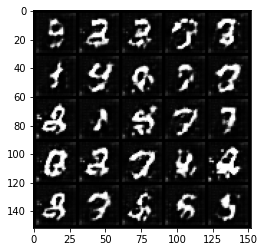

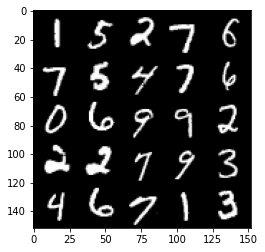

Step 1000: Generator loss: 0.9289455739259717, discriminator loss: 0.5858241535425178


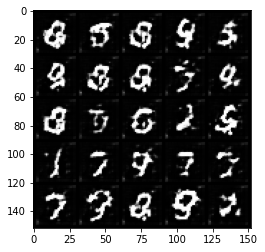

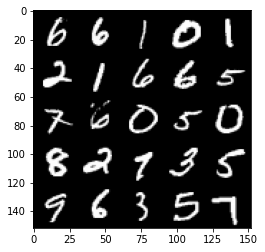

Step 1500: Generator loss: 0.8860009502172475, discriminator loss: 0.5961760588884354


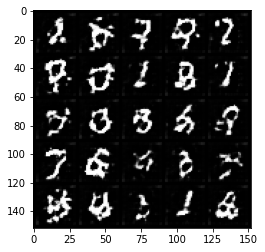

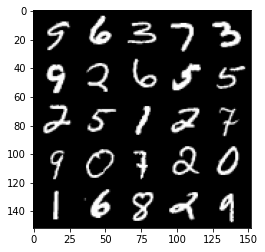

Step 2000: Generator loss: 0.865915327668189, discriminator loss: 0.6130609062910082


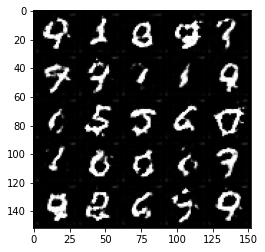

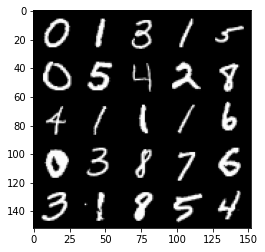

Step 2500: Generator loss: 0.8352177240848541, discriminator loss: 0.626367043018341


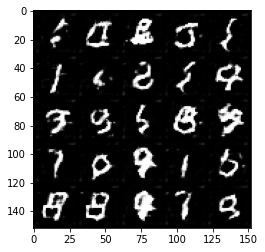

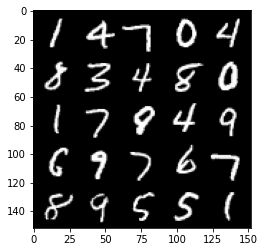

Step 3000: Generator loss: 0.8191660481095312, discriminator loss: 0.6387011817693713


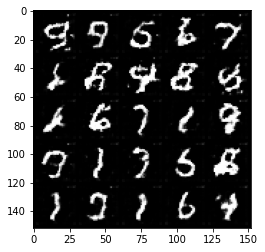

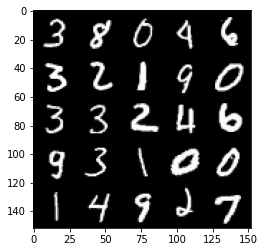

Step 3500: Generator loss: 0.8219799433946602, discriminator loss: 0.6435511772632593


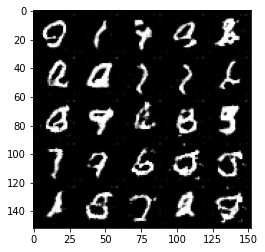

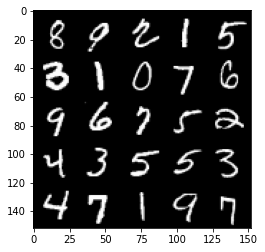

Step 4000: Generator loss: 0.8045041064620013, discriminator loss: 0.6556330050230023


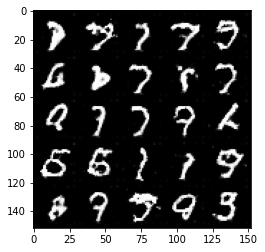

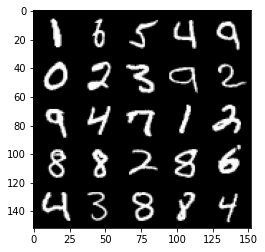

Step 4500: Generator loss: 0.7907504269480705, discriminator loss: 0.6591044738292694


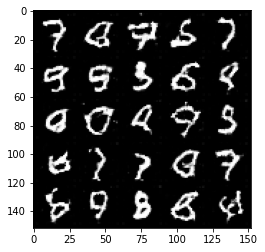

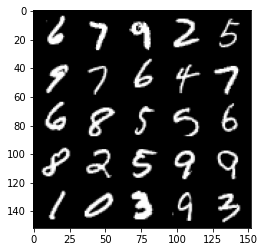

Step 5000: Generator loss: 0.7813597739338881, discriminator loss: 0.6661340978145599


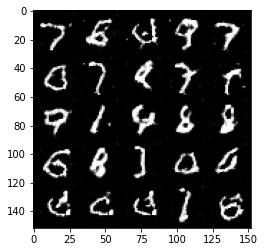

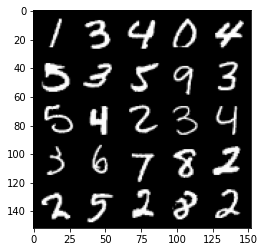

Step 5500: Generator loss: 0.772104639410972, discriminator loss: 0.6714883060455319


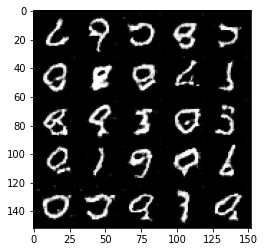

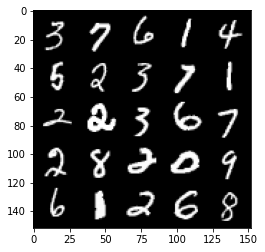

Step 6000: Generator loss: 0.7636398363113404, discriminator loss: 0.6764618054628369


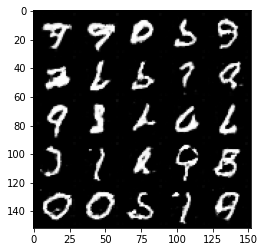

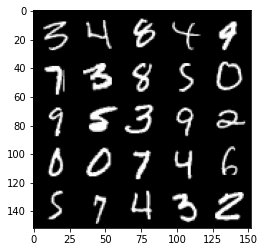

Step 6500: Generator loss: 0.7530132068395613, discriminator loss: 0.6797246992588053


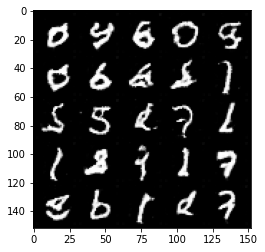

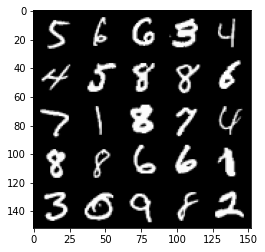

Step 7000: Generator loss: 0.74946768206358, discriminator loss: 0.6838521609306336


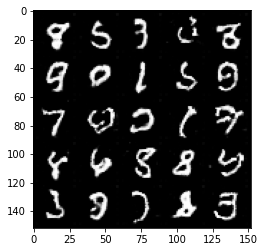

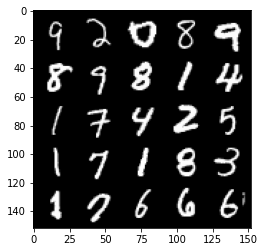

Step 7500: Generator loss: 0.7398831537961954, discriminator loss: 0.6878157899379731


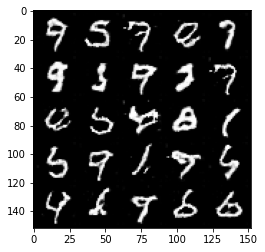

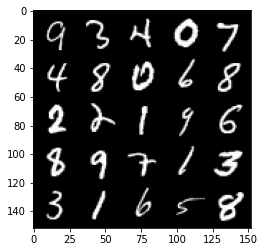

Step 8000: Generator loss: 0.7379465025663368, discriminator loss: 0.6890479775667194


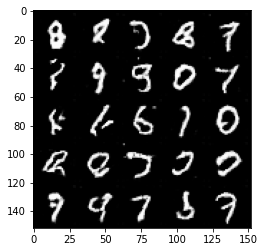

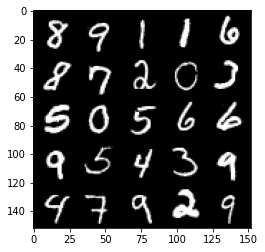

Step 8500: Generator loss: 0.7344707649350181, discriminator loss: 0.6915767743587486


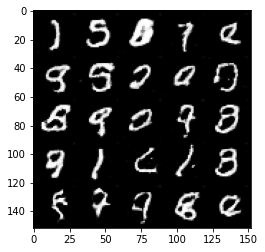

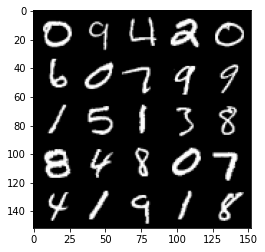

Step 9000: Generator loss: 0.7286436759829521, discriminator loss: 0.6925117902755737


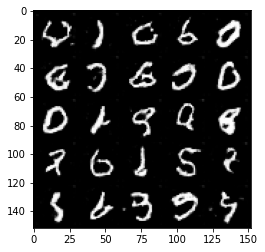

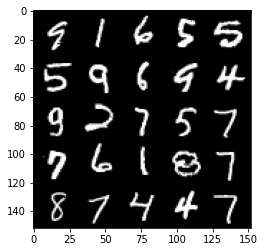

Step 9500: Generator loss: 0.7219557026028636, discriminator loss: 0.6940137401819229


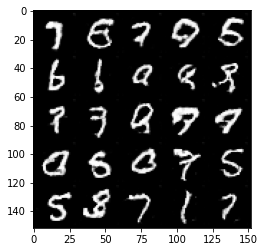

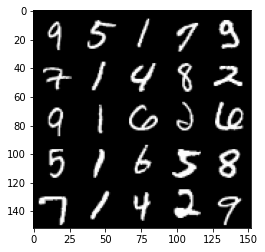

Step 10000: Generator loss: 0.7264781178236009, discriminator loss: 0.6941547549962996


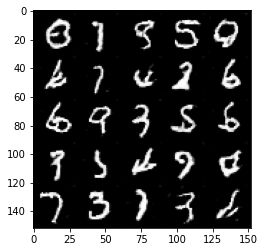

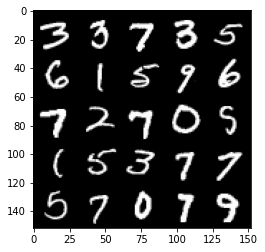

Step 10500: Generator loss: 0.7190367424488073, discriminator loss: 0.6951547466516497


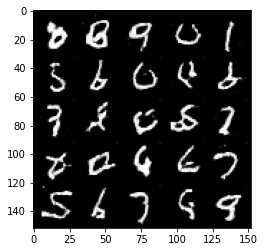

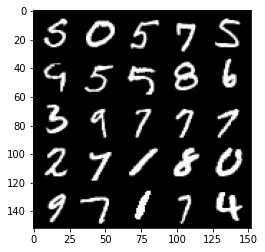

Step 11000: Generator loss: 0.7174159922003742, discriminator loss: 0.6951123882532123


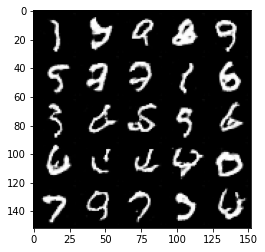

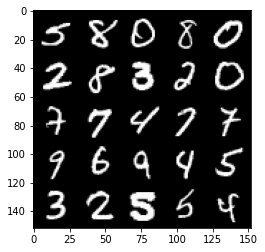

Step 11500: Generator loss: 0.7180764094591142, discriminator loss: 0.6946215817928317


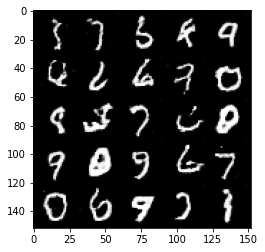

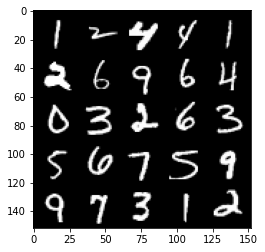

Step 12000: Generator loss: 0.7158219150900841, discriminator loss: 0.6952917748689648


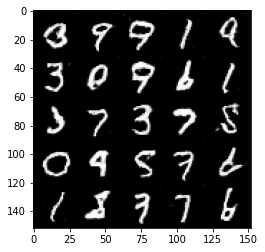

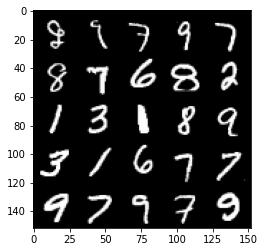

Step 12500: Generator loss: 0.7102330039739612, discriminator loss: 0.6962286763191216


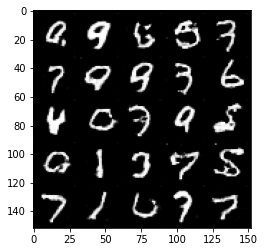

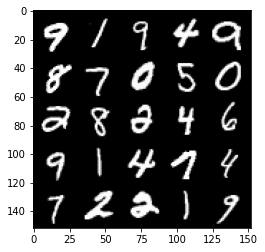

Step 13000: Generator loss: 0.7124335502386093, discriminator loss: 0.6959624863862993


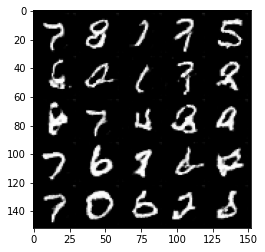

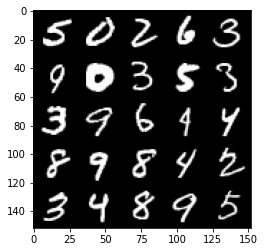

Step 13500: Generator loss: 0.7101754238605498, discriminator loss: 0.6961755018234251


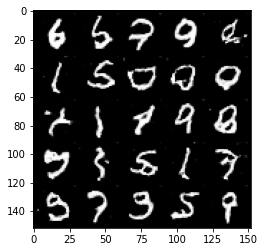

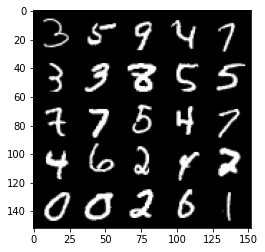

Step 14000: Generator loss: 0.706956835091115, discriminator loss: 0.6966942856311799


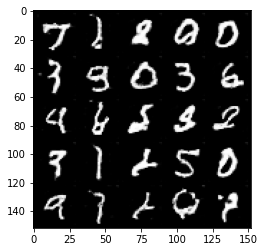

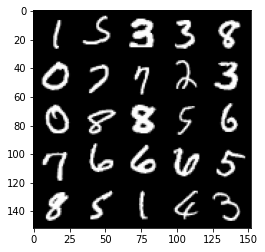

Step 14500: Generator loss: 0.7045185947418204, discriminator loss: 0.6962898517847068


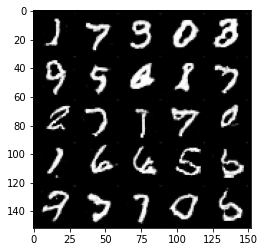

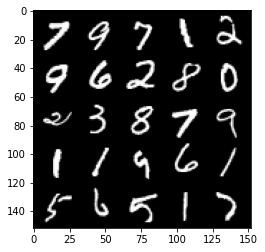

Step 15000: Generator loss: 0.710155081212521, discriminator loss: 0.6962783899307253


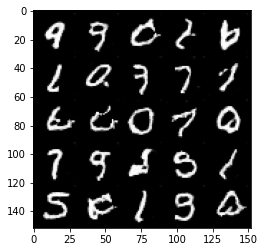

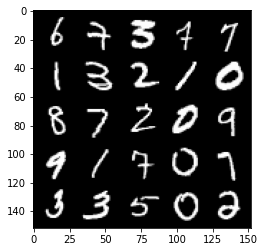

Step 15500: Generator loss: 0.7056238229870804, discriminator loss: 0.6963052119016647


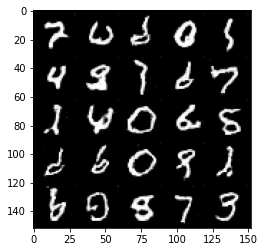

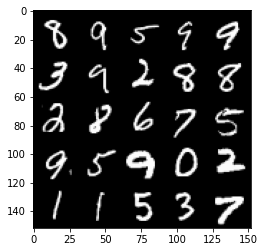

Step 16000: Generator loss: 0.7059538831710815, discriminator loss: 0.6964800094366079


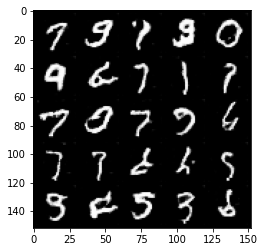

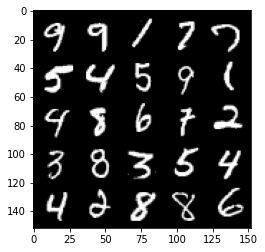

Step 16500: Generator loss: 0.7054178489446647, discriminator loss: 0.6963582364320764


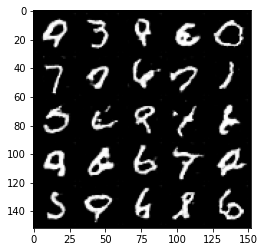

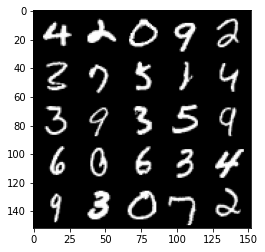

Step 17000: Generator loss: 0.703505673289299, discriminator loss: 0.6959762012958527


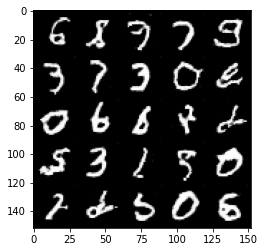

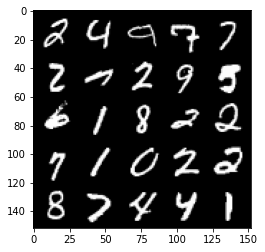

Step 17500: Generator loss: 0.7046296306252477, discriminator loss: 0.6964567425251008


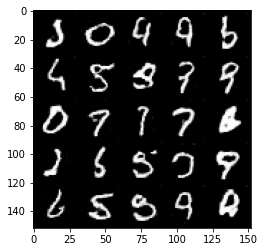

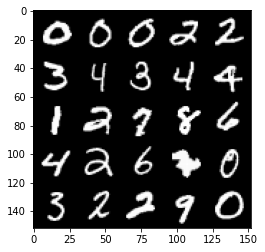

Step 18000: Generator loss: 0.7015031741857528, discriminator loss: 0.6960446718931199


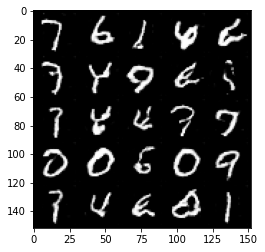

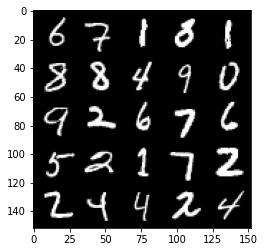

Step 18500: Generator loss: 0.7023843845129012, discriminator loss: 0.6961410596370702


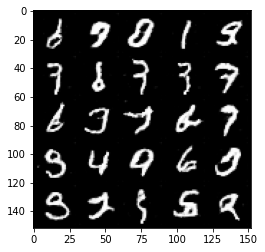

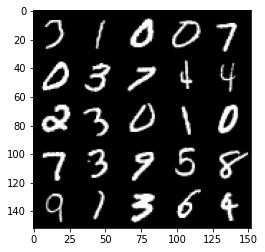

Step 19000: Generator loss: 0.7021399965882302, discriminator loss: 0.6960617891550065


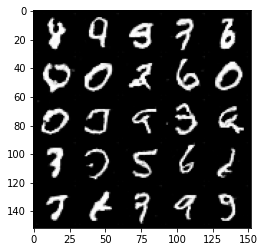

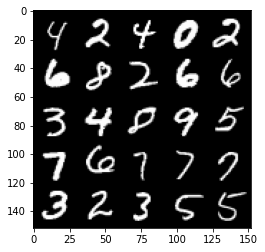

Step 19500: Generator loss: 0.7005832378268246, discriminator loss: 0.696071278572083


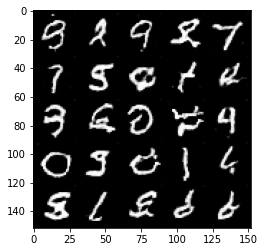

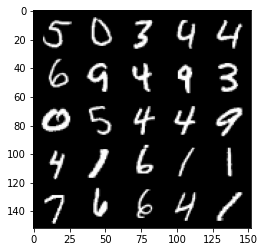

Step 20000: Generator loss: 0.7008198729753496, discriminator loss: 0.696123025298119


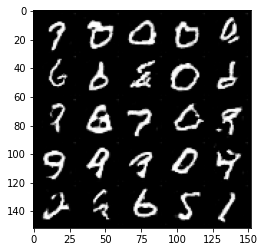

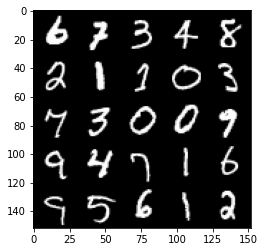

Step 20500: Generator loss: 0.7007811250686646, discriminator loss: 0.6959607427120211


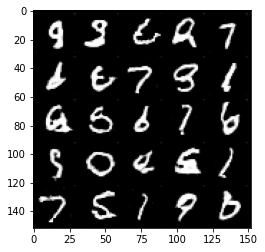

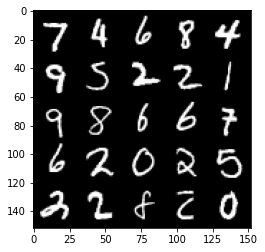

Step 21000: Generator loss: 0.7031833807229992, discriminator loss: 0.6959664831161504


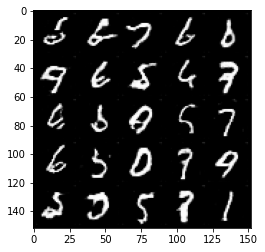

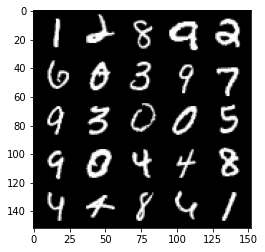

Step 21500: Generator loss: 0.7000279893279073, discriminator loss: 0.6957651674747467


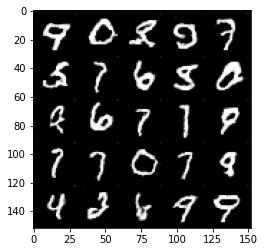

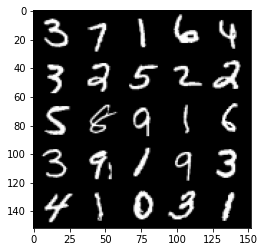

Step 22000: Generator loss: 0.6994824838042264, discriminator loss: 0.6958476363420485


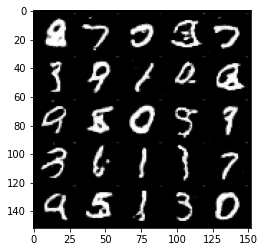

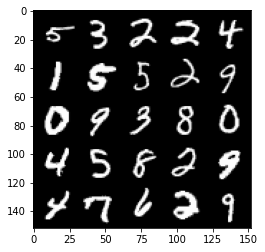

Step 22500: Generator loss: 0.6992449796199802, discriminator loss: 0.6950944733619694


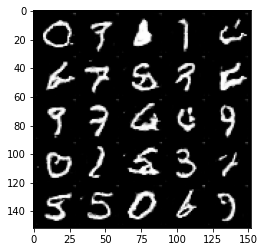

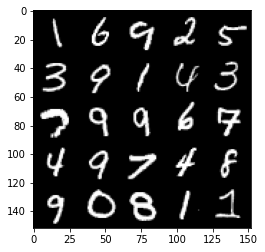

Step 23000: Generator loss: 0.6975947437286371, discriminator loss: 0.6960796290636069


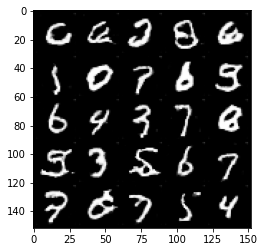

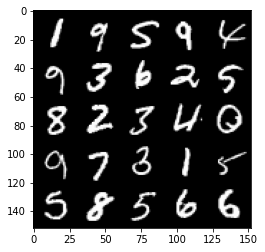

In [ ]:
n_epochs = 50 #more epochs may result in better generation
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Updating discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake_noise=fake_noise.unsqueeze(2)
        fake_noise=fake_noise.unsqueeze(3)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keeping track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Updating gradients
        disc_loss.backward(retain_graph=True)
        # Updating optimizer
        disc_opt.step()

        ## Updating generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_noise_2=fake_noise_2.unsqueeze(2)
        fake_noise_2=fake_noise_2.unsqueeze(3)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keeping track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization of code and output per step ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1